# Assignment 2 Resubmission
**1.convolution with matrix multiplacation**

As it is not possible to compute for the original sixe of the image the image is downsampled by 10x to accomadate for the computation. 


In [ ]:
import numpy as np
from scipy.linalg import toeplitz
from scipy import signal
import time
import cv2
from sklearn.metrics import mean_squared_error 
from google.colab.patches import cv2_imshow


def matrix_to_vector(input):
    """
    Converts the input matrix to a vector by stacking the rows
    
    Arg:
    input -- a numpy matrix
    
    Returns:
    ouput_vector -- a column vector with size input.shape[0]*input.shape[1]
    """
    input_h, input_w = input.shape
    output_vector = np.zeros(input_h*input_w, dtype=input.dtype)
    # flip the input matrix up-down because last row should go first
    input = np.flipud(input) 
    for i,row in enumerate(input):
        st = i*input_w
        nd = st + input_w
        output_vector[st:nd] = row   
    return output_vector


def vector_to_matrix(input, output_shape):
    """
    Reshapes the output of the maxtrix multiplication to the shape "output_shape"
    
    Arg:
    input -- a numpy vector
    
    Returns:
    output -- numpy matrix with shape "output_shape"
    """
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    for i in range(output_h):
        st = i*output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    # flip the output matrix up-down to get correct result
    output=np.flipud(output)
    return output


def convmat(I, F, print_ir=False):
    """
    Performs 2D convolution between input I and filter F by converting the F to a toeplitz matrix and multiply it
      with vectorizes version of I
      
    Arg:
    I -- 2D numpy matrix
    F -- numpy 2D matrix
    print_ir -- if True, all intermediate resutls will be printed after each step of the algorithms
    
    Returns: 
    output -- 2D numpy matrix, result of convolving I with F
    """
    # number of columns and rows of the input 
    I_row_num, I_col_num = I.shape 

    # number of columns and rows of the filter
    F_row_num, F_col_num = F.shape

    #  calculate the output dimensions
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    if print_ir: print('output dimension:', output_row_num, output_col_num)

    # zero pad the filter
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0),
                               (0, output_col_num - F_col_num)),
                            'constant', constant_values=0)
    if print_ir: print('F_zero_padded: ', F_zero_padded)

    # use each row of the zero-padded F to creat a toeplitz matrix. 
    #  Number of columns in this matrices are same as numbe of columns of input signal
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): # iterate from last row to the first row
        c = F_zero_padded[i, :] # i th row of the F 
        r = np.r_[c[0], np.zeros(I_col_num-1)] # first row for the toeplitz fuction should be defined otherwise
                                                            # the result is wrong
        toeplitz_m = toeplitz(c,r) # this function is in scipy.linalg library
        toeplitz_list.append(toeplitz_m)
        if print_ir: print('F '+ str(i)+'\n', toeplitz_m)

        # doubly blocked toeplitz indices: 
    #  this matrix defines which toeplitz matrix from toeplitz_list goes to which part of the doubly blocked
    c = range(1, F_zero_padded.shape[0]+1)
    r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
    doubly_indices = toeplitz(c, r)
    if print_ir: print('doubly indices \n', doubly_indices)

    ## creat doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape # shape of one toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # tile toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape # hight and withs of each block
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

    if print_ir: print('doubly_blocked: ', doubly_blocked)

    # convert I to a vector
    vectorized_I = matrix_to_vector(I)
    if print_ir: print('vectorized_I: ', vectorized_I)
    
    # get result of the convolution by matrix mupltiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)
    if print_ir: print('result_vector: ', result_vector)

    # reshape the raw rsult to desired matrix form
    out_shape = [output_row_num, output_col_num]
    output = vector_to_matrix(result_vector, out_shape)
    if print_ir: print('Result of implemented method: \n', output)
    
    return output




In [ ]:
def conv2dmatrix(image,ker):

  start_time = time.time()
  result = convmat(image,ker)
  end_time = time.time()
  tmtk=end_time-start_time
  print("time",tmtk)
  res=signal.convolve2d(image, ker, "full")
  mse=mean_squared_error(res,result)
  print("error",mse)
  return result

time 0.004967689514160156
error 0.0
[[  1.   2.   2.  -2.  -3.]
 [  5.   7.   4.  -7.  -9.]
 [ 12.  15.   6. -15. -18.]
 [ 11.  13.   4. -13. -15.]
 [  7.   8.   2.  -8.  -9.]]
time 2.212893486022949
error 0.0


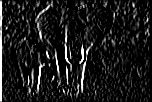

In [ ]:
image=np.array(([1,2,3],[4,5,6],[7,8,9]), dtype = "float")
ker=np.array(([1,0,-1],[1,0,-1],[1,0,-1]),dtype = "float")

k=conv2dmatrix(image,ker)
print(k)

img1=cv2.imread('elephant.jpeg',0)
img13=cv2.resize(img1,None,fx=0.1,fy=0.1)
k1=conv2dmatrix(img13,ker)
cv2_imshow(k1)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

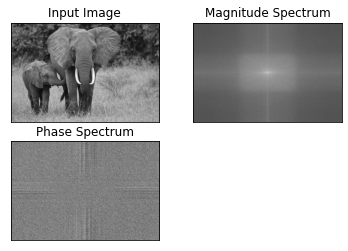

In [ ]:
img=cv2.imread('elephant.jpeg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

phase_spectrum = np.angle(fshift)

plt.subplot(221),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(phase_spectrum,cmap = 'gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])


plt.show()

##Band pass filter
Problem 3.1: Implementation band pass filter

<class 'tuple'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


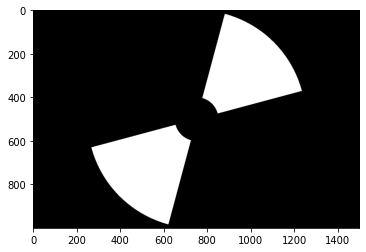

In [ ]:
def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    #print(x,y)
    cx,cy = centre
    print(type(cx))
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    #r2 = (x-cx)(x-cx) + (y-cy)(y-cy)
    xdiff=x-cx
    xdif1=xdiff*xdiff
    ydiff=y-cy
    ydif1=ydiff*ydiff
    r2=xdif1+ydif1
    theta = np.arctan2(x-cx,y-cy) - tmin
    #r2 = (x-cx)(x-cx) + (y-cy)(y-cy)

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    return circmask*anglemask

matrix = np.zeros([1000,1500])
shape=matrix.shape
print(type(shape))
mask = sector_mask(shape,(500,750),500,(105,165))
mask1 = sector_mask(shape,(500,750),500,(285,270+75))
mask3 = sector_mask(shape,(500,750),100,(105,165))
mask4 = sector_mask(shape,(500,750),100,(285,270+75))
mask = mask + mask1 + mask3*-1 + mask4*-1
plt.imshow(mask,cmap='gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


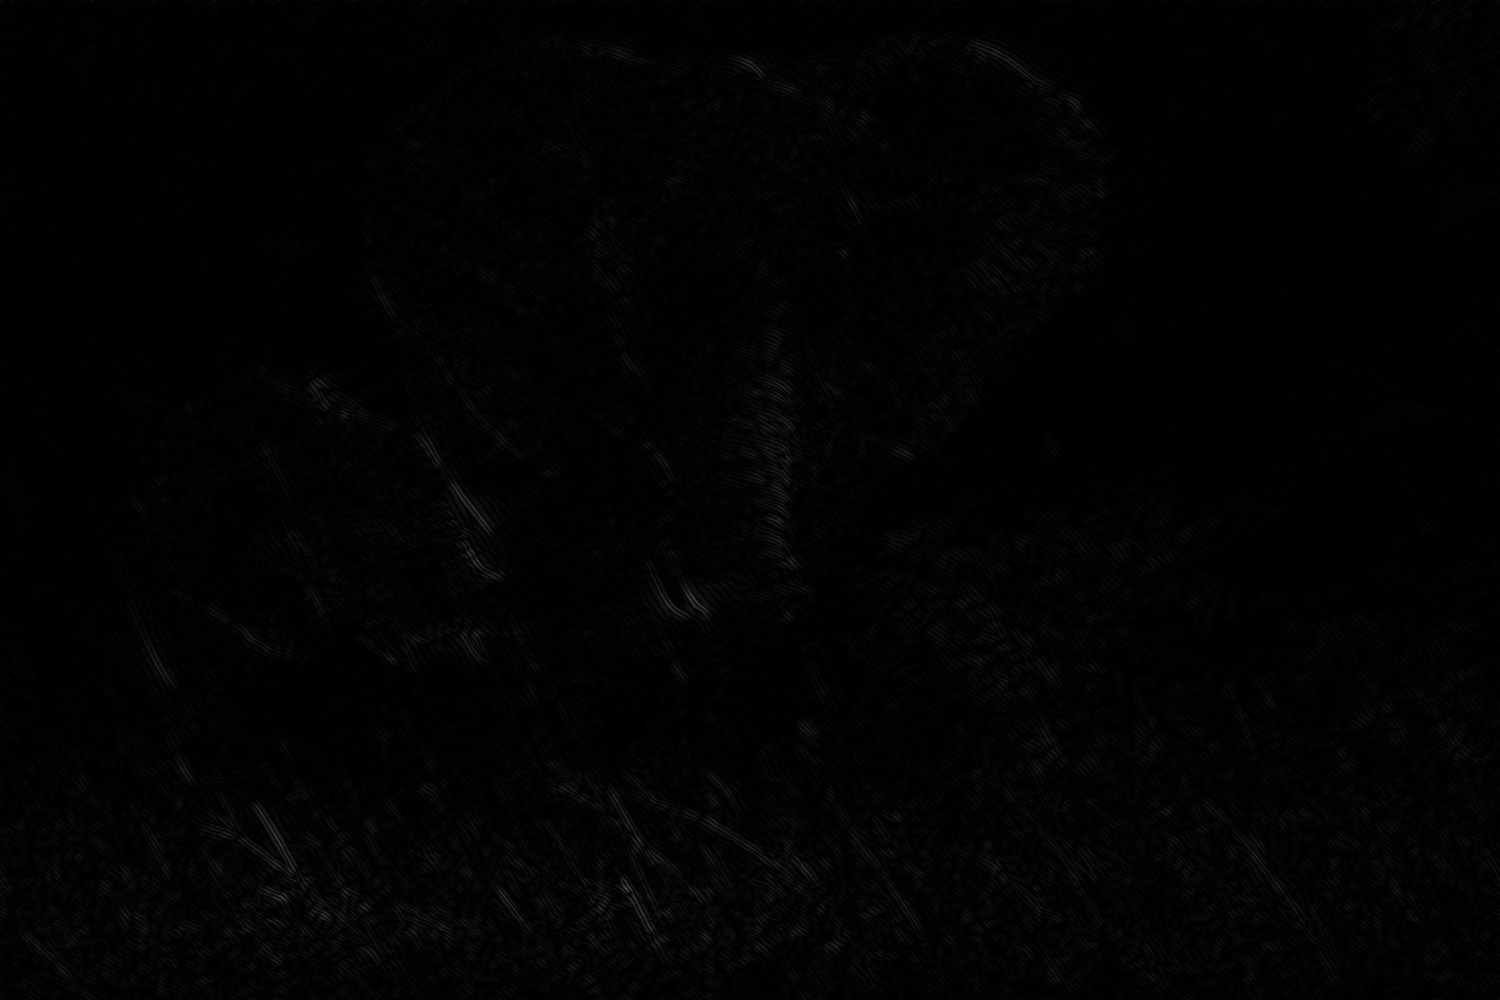

In [ ]:
op=fshift*mask
lp_oput_m = 20*np.log(np.abs(op))
f_ishift_l = np.fft.ifftshift(op)
img_l = np.fft.ifft2(f_ishift_l)
img_lp = np.uint8(np.abs(img_l))
cv2_imshow(img_lp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(Text(0.5, 1.0, 'Phase Spectrum'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

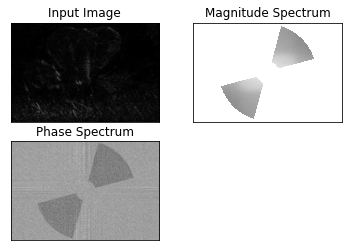

In [ ]:
ms1 = 20*np.log(np.abs(op))

ps1 = np.angle(op)

plt.subplot(221),plt.imshow(img_lp,cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(ms1,cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(ps1, cmap = 'gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])